In [1]:
import os
import random
from typing import Any, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import logging

logging.getLogger().setLevel(logging.INFO)


In [2]:
class SNCFDataset(Dataset):
    """
    A PyTorch Dataset for the SNCF traffic light state dataset.

    This version correctly handles:
    1. Split files that contain full, absolute paths to images.
    2. Label files that contain multiple bounding boxes (one per line).
    """

    def __init__(self, root: str, split: str, transforms: Optional[callable] = None):
        """
        Initializes the SNCFDataset.

        Args:
            root (str): The root directory of the dataset. This is used to find
                        the labels and classes.txt file.
            split (str): The name of the split to load (e.g., 'train', 'calib').
            transforms (callable, optional): A function/transform.
        """
        super().__init__()
        self.root = root
        self.split = split
        self.transforms = transforms

        # The labels directory is still found relative to the root
        self.labels_dir = os.path.join(self.root, "labels")
        self.classes_path = os.path.join(self.root, "classes.txt")

        self.classes = self._load_classes()

        # Load the split file which contains absolute paths to images
        split_file_path = os.path.join(self.root, f"{split}.txt")
        if not os.path.exists(split_file_path):
            raise FileNotFoundError(f"Split file not found: {split_file_path}")

        with open(split_file_path, "r") as f:
            # self.image_files now contains absolute paths, e.g., '/path/to/images/file.jpg'
            self.image_files = [line.strip() for line in f if line.strip()]

        # image ids are just the file names witout extensions or path
        self.image_ids = [
            os.path.splitext(os.path.basename(img_path))[0] for img_path in self.image_files
        ]

        # TODO(leo): to satisfy rthe lib
        self.NAMES = self.classes

    def _load_classes(self) -> dict:
        """Loads class names from classes.txt."""
        with open(self.classes_path, "r") as f:
            classes_raw = f.read().splitlines()
            classes_raw = [c.split(" ") for c in classes_raw if len(c) > 0]
        return {int(c[0]): " ".join(c[1:]) for c in classes_raw}

    def __len__(self) -> int:
        """Returns the total number of images in the dataset for the current split."""
        return len(self.image_files)

    def __getitem__(self, idx: int) -> Tuple[Any, Any, Any, Any]:
        """
        Retrieves an item from the dataset at the specified index.
        """
        img_path = self.image_files[idx]

        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        # To find the label, we still need the base filename (e.g., 'image.jpg')
        base_img_filename = os.path.basename(img_path)
        label_name = os.path.splitext(base_img_filename)[0] + ".txt"

        # Construct the absolute path to the label file
        label_path = os.path.join(self.labels_dir, label_name)

        target = self._load_target(label_path, h, w)

        if self.transforms is not None:
            # Your transform function must accept both image and target
            # img, target = self.transforms(img, target)
            img = self.transforms(img)

        image_size = img.size

        return img_path, image_size, img, target

    def _load_target(self, label_path: str, height: int, width: int) -> dict:
        """
        Loads and processes a label file, handling multiple bounding boxes (lines).
        """
        # --- MODIFICATION START ---
        # Initialize lists to hold all boxes and labels for a single image.
        boxes = []
        labels = []

        if not os.path.exists(label_path):
            # Return empty lists if a label file doesn't exist for an image
            return {"boxes": boxes, "labels": labels}

        with open(label_path, "r") as f:
            # Iterate over each line in the file, as each line is a new bounding box.
            for line in f:
                line = line.strip()
                if not line:
                    continue

                label_data = line.split(" ")

                # Basic validation for a valid YOLO format line
                if len(label_data) < 5:
                    continue

                class_id = label_data[0]
                box_coords = np.array([float(x) for x in label_data[1:5]])

                # Denormalize coordinates
                box_coords = box_coords * np.array([width, height, width, height])

                # Convert (center_x, center_y, w, h) to (x_min, y_min, x_max, y_max)
                x_min = box_coords[0] - box_coords[2] / 2
                y_min = box_coords[1] - box_coords[3] / 2
                x_max = box_coords[0] + box_coords[2] / 2
                y_max = box_coords[1] + box_coords[3] / 2

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(int(class_id))  # self.classes[class_id])

        # The target dictionary now contains a list of boxes and a list of labels.
        return {"boxes": boxes, "labels": labels}
        # --- MODIFICATION END ---

    def _collate_fn(self, batch):
        return list([list(x) for x in zip(*batch)])


In [3]:
from torchvision import transforms

trans = transforms.Compose(
    [
        # transforms.ToTensor(), #
    ]
)
dataset_root_path = "/datasets/shared_datasets/SNCF/DATASET_etat_feu"

# 1. Instantiate the training dataset
# Used for training your model
train_dataset = SNCFDataset(root=dataset_root_path, split="train", transforms=trans)

# 2. Instantiate the validation dataset
# Used for monitoring training and hyperparameter tuning
val_dataset = SNCFDataset(root=dataset_root_path, split="val", transforms=trans)

# 3. Instantiate the calibration dataset
# A hold-out set used ONLY for calibrating your conformal predictor
calib_dataset = SNCFDataset(root=dataset_root_path, split="calib", transforms=trans)

# 4. Instantiate the test dataset
# The final hold-out set used ONLY for evaluating the final, calibrated model
test_dataset = SNCFDataset(root=dataset_root_path, split="test", transforms=trans)


# --- Verification ---
print("Dataset loading complete.")
print("-" * 30)
print(f"Training dataset size:   {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Calibration dataset size:{len(calib_dataset)}")
print(f"Test dataset size:       {len(test_dataset)}")
print("-" * 30)

# Example of accessing a sample from the test set
if len(test_dataset) > 0:
    img_path, _, _, target = test_dataset[0]
    print(f"\nFirst test sample path: {img_path}")
    print(f"First test sample target: {target}")

Dataset loading complete.
------------------------------
Training dataset size:   9047
Validation dataset size: 1292
Calibration dataset size:1292
Test dataset size:       1294
------------------------------

First test sample path: /datasets/shared_datasets/SNCF/DATASET_etat_feu/images/EdPCfoF681.jpg
First test sample target: {'boxes': [[np.float64(487.0003976), np.float64(332.999856), np.float64(530.0003704), np.float64(400.999824)]], 'labels': [23]}


In [4]:
from cods.od.models import YOLOModel

model = YOLOModel(
    # model_name="./runs/detect/yolov8_sncf_augmented_training4/weights/best.pt",
    model_name="cods-sncf/yolo11x_sncf/weights/best.pt",
    pretrained=True,
    is_coco=False,
)

In [5]:
preds_cal = model.build_predictions(
    calib_dataset,
    dataset_name="sncf",
    split_name="cal",
    batch_size=12,
    collate_fn=calib_dataset._collate_fn,  # TODO: make this a default for COCO
    shuffle=False,
    force_recompute=True,
    deletion_method="nms",
    filter_preds_by_confidence=1e-3,
)
preds_test = model.build_predictions(
    test_dataset,
    dataset_name="sncf",
    split_name="test",
    batch_size=12,
    collate_fn=test_dataset._collate_fn,
    shuffle=False,
    force_recompute=True,
    deletion_method="nms",
    filter_preds_by_confidence=1e-3,
)

File ./saved_predictions/120087f9a23624d3ae19db3d1f1d7fa4bd429be9be9828edb253716f512e921b.pkl does not exist


Predictions do not exist, building them...


100%|██████████| 108/108 [14:15<00:00,  7.92s/it]
File ./saved_predictions/ad7fff6ee1e0873177b112928cc78b0fc105897b7585c6b64b215bcbf0f2d90b.pkl does not exist


Predictions do not exist, building them...


100%|██████████| 108/108 [14:03<00:00,  7.81s/it]


In [6]:
from cods.od.cp import ODConformalizer

conf = ODConformalizer(
    backend="auto",
    guarantee_level="image",
    matching_function="mix",
    multiple_testing_correction=None,
    confidence_method="box_count_recall",
    localization_method="pixelwise",
    localization_prediction_set="multiplicative",
    classification_method="binary",
    classification_prediction_set="lac",
)

[2025-06-16 08:06:37:WARNING:cp.py:cp:783 - __init__ ] No multiple_testing_correction provided, assuming no correction is needed. The explicit list of alphas is expected for calibration.
[2025-06-16 08:06:37:INFO:cp.py:cp:184 - __init__ ] Defaulting to CRC backend
[2025-06-16 08:06:37:INFO:cp.py:cp:535 - __init__ ] Defaulting to CRC backend


In [7]:
parameters = conf.calibrate(
    preds_cal,
    alpha_confidence=0.02,
    alpha_localization=0.08,
    alpha_classification=0.02,
)


[2025-06-16 08:06:37:INFO:cp.py:cp:1023 - calibrate ] Calibrating Confidence Conformalizer
  0%|          | 0/1292 [00:00<?, ?it/s]/home/leo.andeol/envs/cods_13/cods/cods/od/utils.py:501: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  Qst = torch.FloatTensor([Qs]).to(device)
100%|██████████| 1292/1292 [00:00<00:00, 2200.83it/s]


First risk: 0.0007733951788395643


λ=0.871318519115448. Corrected Risk = 0.0201:  72%|███████▏  | 4237/5851 [00:09<00:03, 449.04it/s]


--------------------------------------------------
Lambdas
	previous_lbd = 0.871402382850647
	Last Lambda = 0.871318519115448
	Other previous lbd = 0.871402382850647
	Other current lbd = 0.871318519115448
All risks raw (precomputed):
	Confidence Risk: 0.019334880635142326
	Localization Risk: 0.019334880635142326
	Classification Risk: 0.0007733951788395643
	Max Risk: 0.019334880635142326
All risks monotonized (precomputed):
	Confidence Risk: 0.019334880635142326
	Localization Risk: 0.019334880635142326
	Classification Risk: 0.0007733951788395643
	Max Risk: 0.019334880635142326
Confidence risk (recomputed):
	Confidence Risk: 0.020123839378356934
Comparison of the two :
	 (isclose) 0.9992260336875916
	 (eq) 0.9992260336875916
	Image 1182 loss: tensor([1.]) (eval) vs tensor([0.]) (opti)
	Image 1182 confidence: tensor([2.1881e-08])
	Image 1182 number of ground truths: 1
	Image 1182 number of predictions: 0
--------------------------------------------------


100%|██████████| 1292/1292 [00:00<00:00, 3203.10it/s]


First risk: 0.0


λ=0.8559457063674927. Corrected Risk = 0.0201:  73%|███████▎  | 4248/5851 [00:09<00:03, 435.20it/s]
[2025-06-16 08:06:58:INFO:cp.py:cp:1033 - calibrate ] Setting Confidence Threshold of Predictions
[2025-06-16 08:06:58:INFO:cp.py:cp:1045 - calibrate ] Calibrated Confidence λ : 0.8714
	 and associated Confidence Threshold : 0.12859761714935303
[2025-06-16 08:06:58:INFO:cp.py:cp:1060 - calibrate ] Matching Predictions to True Boxes


--------------------------------------------------
Lambdas
	previous_lbd = 0.8616198301315308
	Last Lambda = 0.8559457063674927
	Other previous lbd = 0.8616198301315308
	Other current lbd = 0.8559457063674927
All risks raw (precomputed):
	Confidence Risk: 0.019334880635142326
	Localization Risk: 0.019334880635142326
	Classification Risk: 0.0
	Max Risk: 0.019334880635142326
All risks monotonized (precomputed):
	Confidence Risk: 0.019334880635142326
	Localization Risk: 0.019334880635142326
	Classification Risk: 0.0
	Max Risk: 0.019334880635142326
Confidence risk (recomputed):
	Confidence Risk: 0.02089783363044262
Comparison of the two :
	 (isclose) 0.9992260336875916
	 (eq) 0.9992260336875916
	Image 1182 loss: tensor([1.]) (eval) vs tensor([0.]) (opti)
	Image 1182 confidence: tensor([2.1881e-08])
	Image 1182 number of ground truths: 1
	Image 1182 number of predictions: 0
--------------------------------------------------


1292it [00:00, 9676.88it/s]
[2025-06-16 08:06:58:INFO:cp.py:cp:1073 - calibrate ] Calibrating Localization Conformalizer
[2025-06-16 08:06:58:INFO:cp.py:cp:248 - calibrate ] Using overload confidence threshold: 0.1384
[0.78, 0.81] -> λ=0.79345703125. Corrected Risk = 0.08: 100%|██████████| 13/13 [00:33<00:00,  2.57s/it]
[2025-06-16 08:07:32:INFO:cp.py:cp:289 - calibrate ] Calibrated λ for localization: 0.8056640625
[2025-06-16 08:07:32:INFO:cp.py:cp:1083 - calibrate ] Calibrated Localization λ : 0.8056640625
[2025-06-16 08:07:32:INFO:cp.py:cp:1091 - calibrate ] Calibrating Classification Conformalizer
[2025-06-16 08:07:32:INFO:cp.py:cp:574 - calibrate ] Using overload confidence threshold: 0.1384
[2025-06-16 08:07:32:WARNING:cp.py:cp:579 - calibrate ] Currently considering that there is only one matching prediction to each true box for classification pruposes. To add later how to aggregate if multiple preidctions matched.
[0.97, 0.97] -> λ=0.9742743074893951. Corrected Risk = 0.02: 100

In [8]:
conformal_preds = conf.conformalize(preds_test, parameters=parameters)

[2025-06-16 08:08:21:INFO:cp.py:cp:1143 - conformalize ] Conformalizing Predictions
[2025-06-16 08:08:21:INFO:cp.py:cp:1146 - conformalize ] Using provided parameters for conformalization
[2025-06-16 08:08:21:INFO:cp.py:cp:1152 - conformalize ] The parameters have been computed on another set of predictions.
[2025-06-16 08:08:21:INFO:cp.py:cp:1164 - conformalize ] Conformalizing Confidence
[2025-06-16 08:08:21:INFO:cp.py:cp:1183 - conformalize ] Conformalizing Localization
[2025-06-16 08:08:21:INFO:cp.py:cp:334 - conformalize ] Using previous λ for localization
[2025-06-16 08:08:21:INFO:cp.py:cp:349 - conformalize ] Conformalizing Localization with λ
[2025-06-16 08:08:21:INFO:cp.py:cp:1194 - conformalize ] Conformalizing Classification


In [9]:
results_test = conf.evaluate(
    preds_test,
    parameters=parameters,
    conformalized_predictions=conformal_preds,
    include_confidence_in_global=False,
)

Confidence threshold is 0.12859761714935303
Matching is : True
Matching complete
Confidence threshold: 0.12859761714935303
ODParameters
global_alpha: 0.12000000000000001
alpha_confidence: 0.02
alpha_localization: 0.08
alpha_classification: 0.02
lambda_confidence_plus: 0.871402382850647
lambda_confidence_minus: 0.8616198301315308
lambda_localization: 0.8056640625
lambda_classification: 0.9742743074893951
confidence_threshold: 0.12859761714935303


[2025-06-16 08:08:22:INFO:cp.py:cp:1255 - evaluate ] Evaluation Results:
[2025-06-16 08:08:22:INFO:cp.py:cp:1257 - evaluate ] 	 Confidence:
[2025-06-16 08:08:22:INFO:cp.py:cp:1258 - evaluate ] 		 Risk: 0.02
[2025-06-16 08:08:22:INFO:cp.py:cp:1259 - evaluate ] 		 Mean Set Size: 1.23
[2025-06-16 08:08:22:INFO:cp.py:cp:1263 - evaluate ] 	 Localization:
[2025-06-16 08:08:22:INFO:cp.py:cp:1264 - evaluate ] 		 Risk: 0.08
[2025-06-16 08:08:22:INFO:cp.py:cp:1265 - evaluate ] 		 Mean Set Size: 2.56
[2025-06-16 08:08:22:INFO:cp.py:cp:1269 - evaluate ] 	 Classification:
[2025-06-16 08:08:22:INFO:cp.py:cp:1270 - evaluate ] 		 Risk: 0.02
[2025-06-16 08:08:22:INFO:cp.py:cp:1271 - evaluate ] 		 Mean Set Size: 4.32
[2025-06-16 08:08:22:INFO:cp.py:cp:1275 - evaluate ] 	 Global:
[2025-06-16 08:08:22:INFO:cp.py:cp:1279 - evaluate ] 		 Risk: 0.08293115347623825


Using confidence threshold from preds


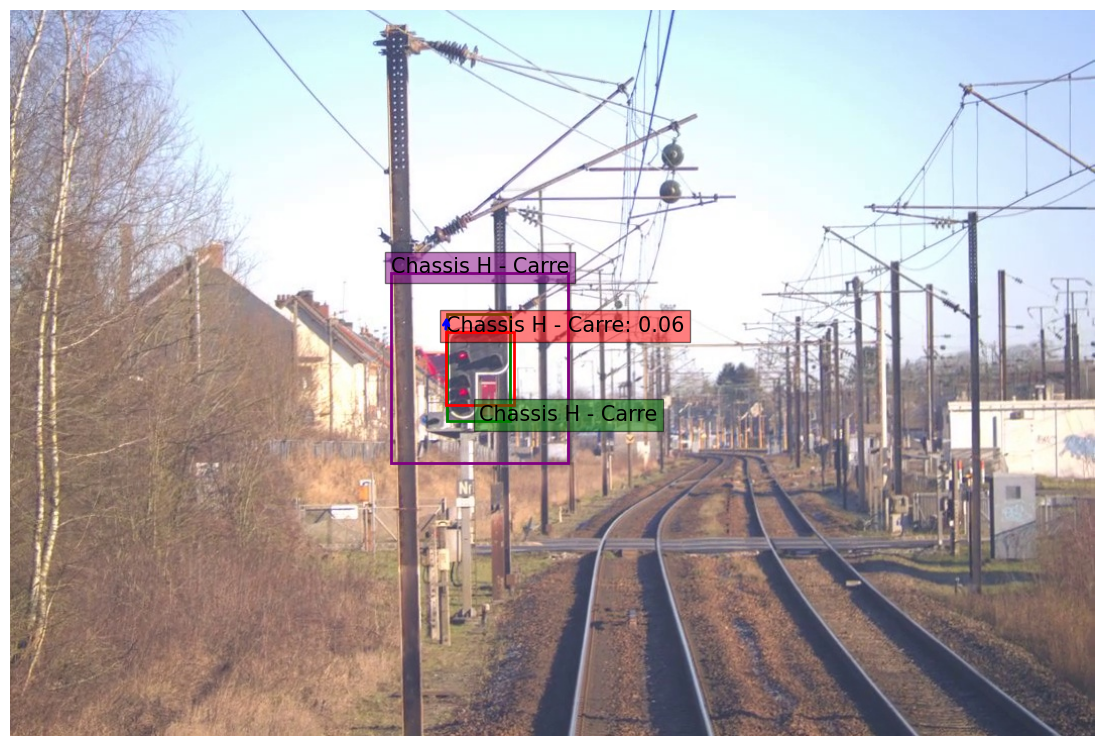

Using confidence threshold from preds


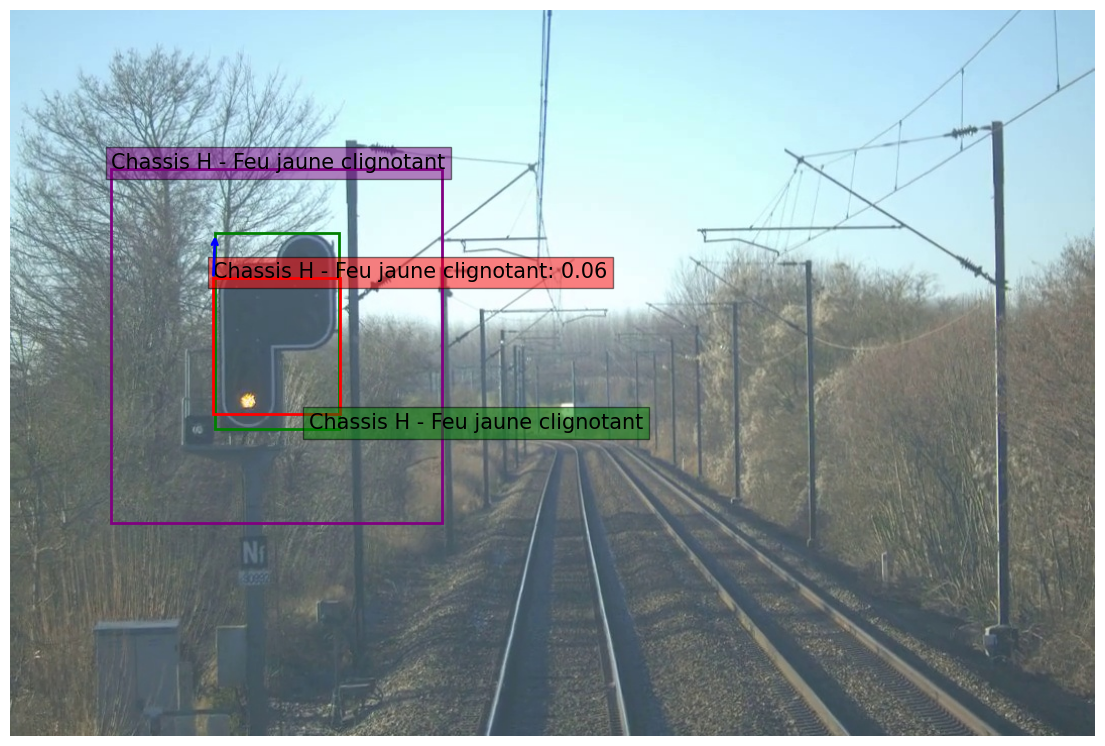

Using confidence threshold from preds


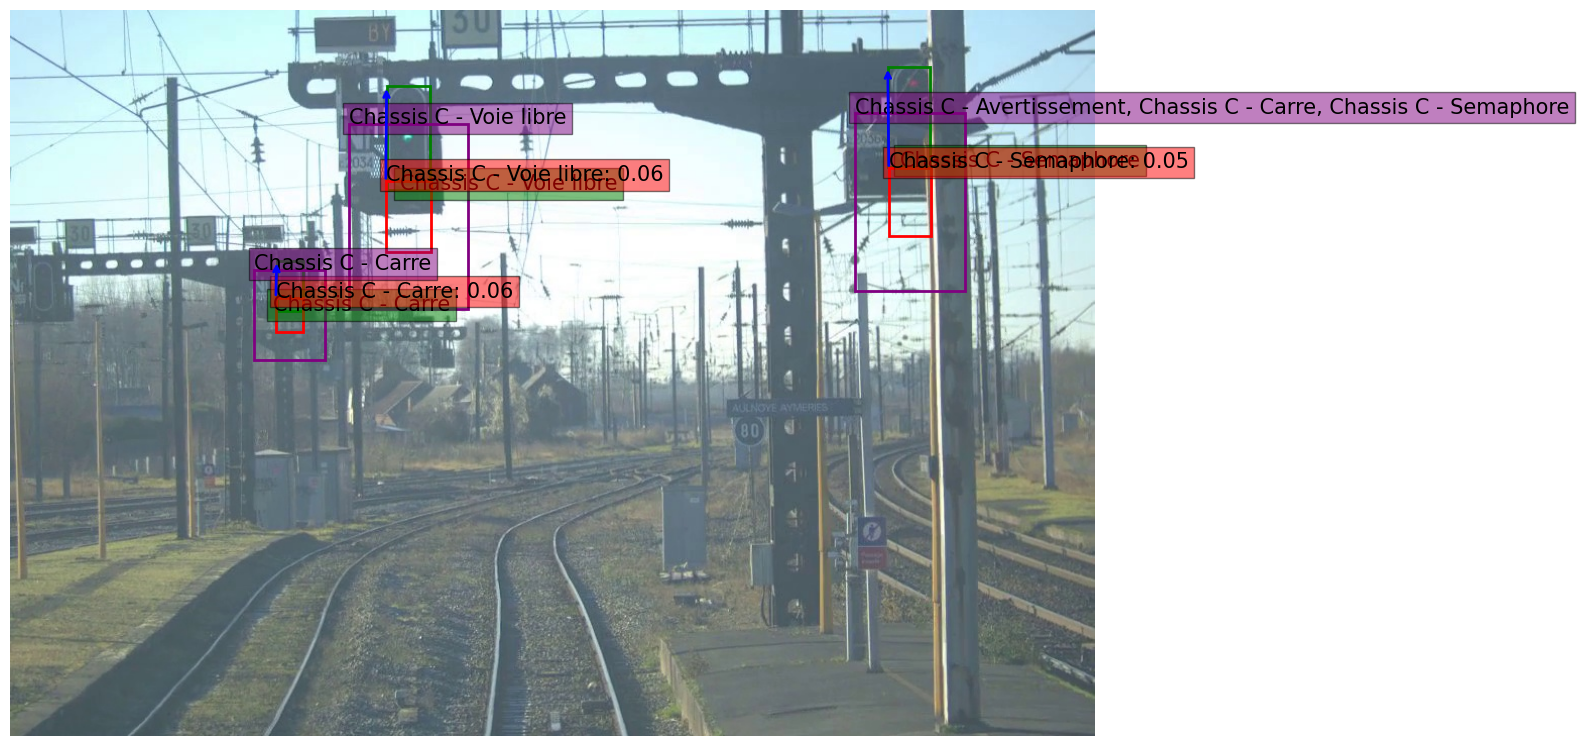

Using confidence threshold from preds


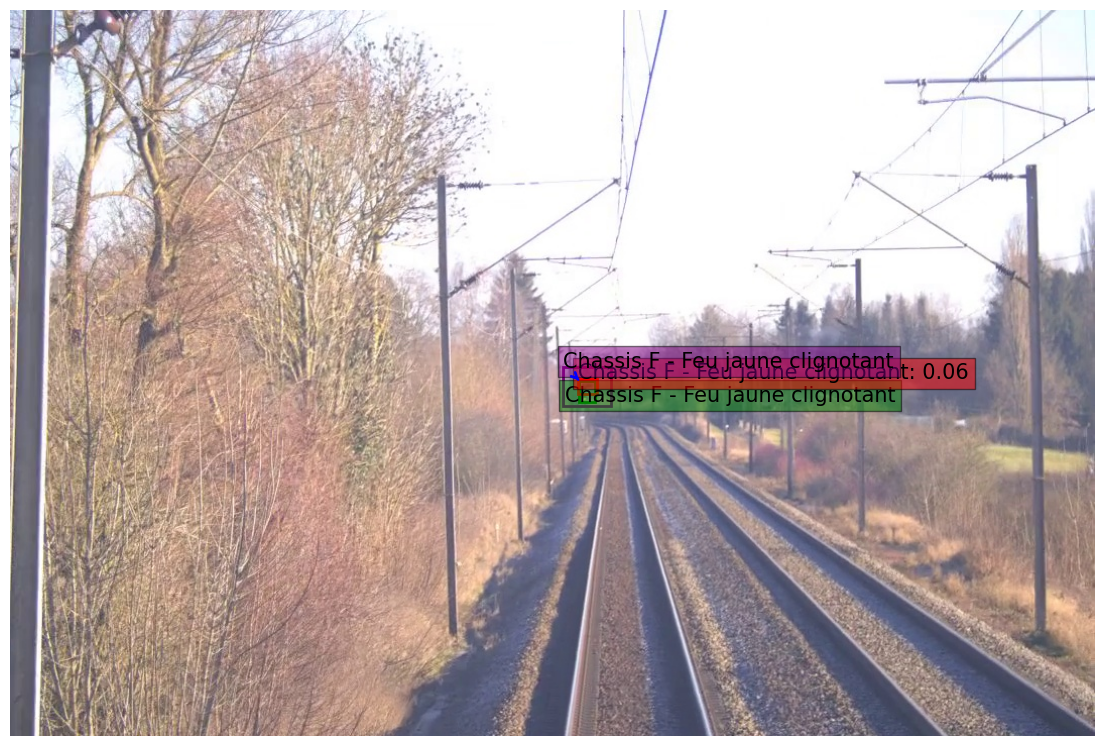

Using confidence threshold from preds


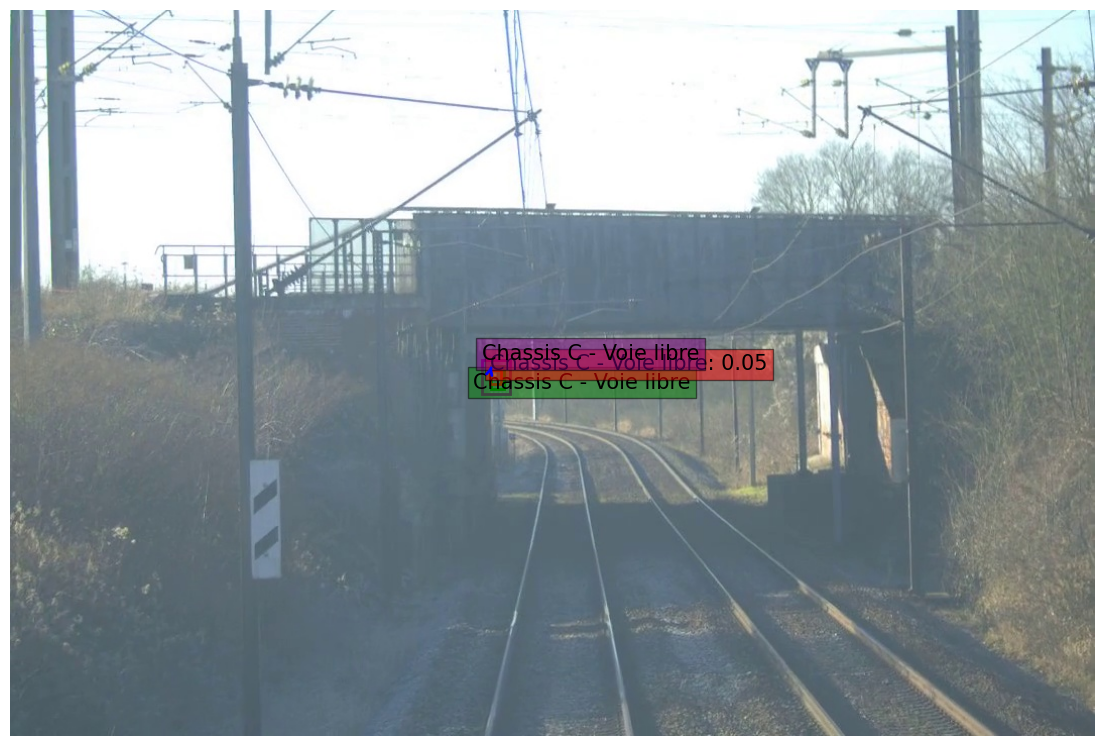

In [11]:
from cods.od.visualization import plot_preds

for i in range(5):
    idx = random.randint(0, len(preds_test) - 1)
    plot_preds(idx, preds_test, conformal_preds, idx_to_label=test_dataset.NAMES)